In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.sparse import csr_matrix, dok_matrix, diags
from scipy.sparse.linalg import svds, expm
from sklearn.decomposition import TruncatedSVD

In [2]:
links = pd.read_csv("./data/stack_network_links.csv")
nodes = pd.read_csv("./data/stack_network_nodes.csv")

In [3]:
links.head()

,source,target,value
0,azure,.net,20.933192
1,sql-server,.net,32.322524
2,asp.net,.net,48.407030
3,entity-framework,.net,24.370903
4,wpf,.net,32.350925


In [4]:
nodes.head()

,name,group,nodesize
0,html,6,272.45
1,css,6,341.17
2,hibernate,8,29.83
3,spring,8,52.84
4,ruby,3,70.14


In [5]:
def get_adj(nodes, edges, label_a="source", label_b="target"):
    NN = len(nodes.unique())
    mappings = {}
    c=0
    adj = np.zeros((NN,NN))
    
    for e in edges.index:
        i, j = edges.loc[e, label_a], edges.loc[e, label_b]
        if i in mappings:
            i = mappings[i]
        else:
            mappings[i]=i=c
            c+=1
        if j in mappings:
            j = mappings[j]
        else:
            mappings[j]=j=c
            c+=1
        adj[i, j] = 1#edges.loc[e, "value"]
    return adj, mappings

In [6]:
def grap_rep(A, k, β, d=10, α=1e-6):
    D = A.sum(axis=1)
    A = np.matrix(
        np.divide(A, D, where=D!=0)
    )

    A_k = np.array([
        A**i for i in range(1,k+1)
    ])
    Rep = np.zeros((A.shape[0], d*k))
    
    for i, A in enumerate(A_k):
        X = np.log(
            (A+α) / (A.sum(axis=1) + α)
        ) - np.log(β)
        X[X<0]=0
        
        svd = TruncatedSVD(n_components=d, n_iter=100).fit(X)
        Ud=svd.transform(X)
        Sd = np.diag(svd.singular_values_)
        W = Ud @ Sd**(0.5)
        
        Rep[:, i*d:(i+1)*d] = W
        
    return Rep

In [7]:
graph, maps = get_adj(nodes.name, links)

In [8]:
A = (graph!=0)*1

In [9]:
def plot_graph(G, show_labels=False, node_size=10, figsize=(6,6)):
    f, ax = plt.subplots(1,1, figsize=figsize)
    display = display = nx.spring_layout(G)
    
    nx.draw_networkx_nodes(G, nodelist=G.nodes, pos=display, node_size = node_size, ax=ax, alpha=0.3)
    
    if show_labels==True:
        nx.draw_networkx_labels(G, pos=display, ax=ax)
    
    nx.draw_networkx_edges(G, pos=display, edgelist=G.edges, ax=ax, arrows=False)

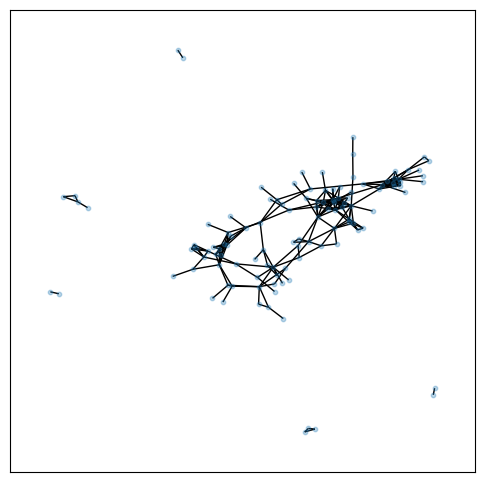

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
g=nx.Graph()
g.add_edges_from(np.argwhere(A!=0))
plot_graph(g)

## Supervised Methods

In [11]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, 
                             matthews_corrcoef, accuracy_score)

In [24]:
latent_vecs = grap_rep(A, k=3, β=0.001, d=15)
order = np.argsort(nodes.name.map(maps))

In [25]:
print("Sparsity = ", (latent_vecs==0).sum()/np.prod(latent_vecs.shape))

Sparsity =  0.0


In [26]:
y = nodes.loc[ order, "group" ]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(latent_vecs, y, test_size=0.2, random_state=3)

In [28]:
svc = SVC().fit(X_train, y_train)
lr = LogisticRegression(max_iter=9999).fit(X_train, y_train)
print(f"SVC score = {svc.score(X_train, y_train):.3f}\nLR score = {lr.score(X_train, y_train):.3f}")

SVC score = 0.902
LR score = 0.957


In [29]:
print(
    "Random Assignment Score =",accuracy_score(y_train, np.random.randint(1,14+1, len(y_train)))
)

Random Assignment Score = 0.06521739130434782


In [30]:
svc_preds = svc.predict(X_test)
lr_preds = lr.predict(X_test)

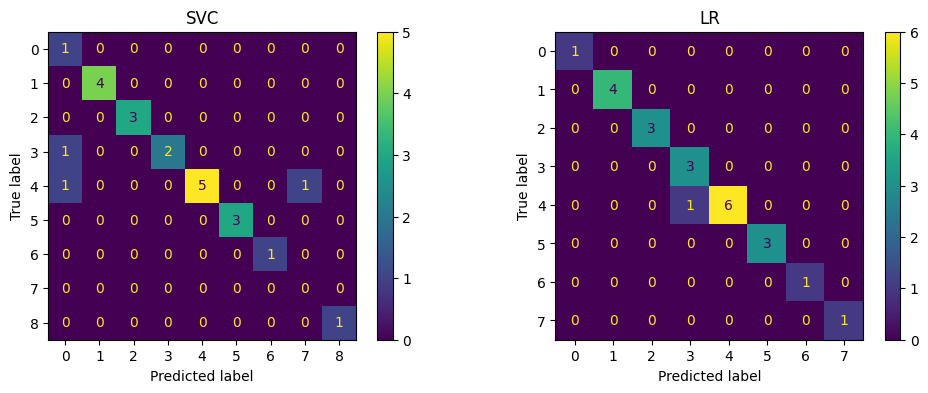

In [31]:
f, ax = plt.subplots(1,2,figsize=(12,4))
ConfusionMatrixDisplay(confusion_matrix(y_test, svc_preds)).plot(ax=ax[0])
ConfusionMatrixDisplay(confusion_matrix(y_test, lr_preds)).plot(ax=ax[1])

ax[0].set_title("SVC");
ax[1].set_title("LR");

In [32]:
print(f"SVC mcc score = {matthews_corrcoef(y_test, svc_preds):.3f}\nLR mcc score = {matthews_corrcoef(y_test, lr_preds):.3f}")

SVC mcc score = 0.856
LR mcc score = 0.950


In [33]:
print(f"SVC acc score = {accuracy_score(y_test, svc_preds):.3f}\nLR acc score = {accuracy_score(y_test, lr_preds):.3f}")

SVC acc score = 0.870
LR acc score = 0.957


In [34]:
print(
    "Random Assignment Score =",accuracy_score(y_test, np.random.randint(1,14+1, len(y_test)))
)

Random Assignment Score = 0.043478260869565216


By tunning *k, d and $\beta$* values we could improve model performance.